# Tutorial 2: Annotate cell types in single-cell RNA-seq data

Welcome to this tutorial on annotating single-cell datasets with reference collections. The **scRNAseq** ([R/Bioc](https://bioconductor.org/packages/devel/data/experiment/html/scRNAseq.html), [Python](https://github.com/BiocPy/scrnaseq)) package provides access to public single-cell RNA-seq datasets for use by other Bioconductor/BiocPy packages and workflows. These datasets are stored in language-agnostic representations described in [ArtifactDB](https://github.com/artifactdb), enabling easy access to datasets and analysis results across multiple programming languages such as R and Python. We will showcase how to integrate and process single-cell datasets across languages, such as R and Python, and how to annotate cell types using reference datasets.

## Outline

In this tutorial, we'll walk through how to:

1. Explore the `scrnaseq` package and access public single-cell RNA-seq datasets.
2. Perform basic operations on `SingleCellExperiment` objects, the core data structure for single-cell data.
3. Annotate cell types using reference datasets from the `celldex` package.

## Prerequisites

Before we begin, please ensure that you have the following prerequisites installed:

- Python 3.8 or later with dependencies listed [here](https://github.com/BiocPy/BiocWorkshop2024/blob/master/requirements.txt).
- R 4.4.0 and Bioconductor packages listed [here](https://github.com/BiocPy/BiocWorkshop2024/blob/master/rpackages.R).

Install the Python packages using pip:

```sh
pip install scrnaseq celldex singler
```

Install the R packages using BiocManager:

```r
BiocManager::install(c("scRNAseq", "celldex", "SingleR"), 
     repos='http://cran.us.r-project.org')
```

## 1. Accessing and exploring single-cell datasets

Let's explore the `scrnaseq` package and learn how to access public single-cell RNA-seq datasets. Datasets published to the `scrnaseq` package are decorated with metadata such as the study title, species, number of cells, etc., to facilitate discovery. Let's see how we can list and search for datasets.

### 1.1 List all datasets

The `list_datasets()` function in Python or `surveyDatasets()` in R will display all available datasets published to the `scRNAseq` collection along with their metadata. To list all available datasets in the `scrnaseq` package and displays their names, titles, and versions:

In [1]:
import scrnaseq
datasets = scrnaseq.list_datasets()
datasets[["name", "title", "version"]].head(3)

,name,title,version
0,aztekin-tail-2019,Identification of a regeneration-organizing ce...,2023-12-14
1,splicing-demonstration-2020,"[reprocessed, subset] The Mammalian Spermatoge...",2023-12-20
2,marques-brain-2016,Oligodendrocyte heterogeneity in the mouse juv...,2023-12-19


#### R
```r
suppressMessages(library(scRNAseq))
all_ds <- surveyDatasets()
head(all_ds[, c("name", "title", "version")], 3)
```

### 1.2 Search for datasets

You can also search for datasets based on metadata using `search_datasets()` in Python or `searchDatasets()` in R. This supports both simple text queries and complex boolean expressions.

Let's search for datasets containing the term "pancreas" and displays their names, titles, and versions.

In [2]:
import scrnaseq

pancreas_datasets = scrnaseq.search_datasets("pancreas")
pancreas_datasets[["name", "title", "version"]].head(3)

,name,title,version
0,grun-bone_marrow-2016,De Novo Prediction of Stem Cell Identity using...,2023-12-14
1,muraro-pancreas-2016,A Single-Cell Transcriptome Atlas of the Human...,2023-12-19
2,baron-pancreas-2016,A Single-Cell Transcriptomic Map of the Human ...,2023-12-14


#### R
```r
pancreas_ds <- searchDatasets("pancreas")
head(pancreas_ds[, c("name", "title", "version")], 3)
```

#### 1.2.1 Advanced searches

For more complex searches involving boolean operations, use `define_text_query()` in Python or `defineTextQuery()` in R. Here's an example to find datasets using the mouse reference genome (`GRCm38`) and containing the words `neuro` or `pancrea`.

```{tip}
Check out the reference manual for more details and usage of these functions.
```

In [3]:
from gypsum_client import define_text_query
import scrnaseq

res = scrnaseq.search_datasets(
     define_text_query("GRCm38", field="genome")
     & (
          define_text_query("neuro%", partial=True)
          | define_text_query("pancrea%", partial=True)
     )
)
res[["name", "title", "version"]].head(3)

,name,title,version
0,grun-bone_marrow-2016,De Novo Prediction of Stem Cell Identity using...,2023-12-14
1,campbell-brain-2017,A molecular census of arcuate hypothalamus and...,2023-12-14
2,hu-cortex-2017,Dissecting cell-type composition and activity-...,2023-12-20


#### R
```r
suppressWarnings(library(gypsum))
res <- searchDatasets(
    defineTextQuery("GRCm38", field="genome") &
    (defineTextQuery("neuro%", partial=TRUE) | 
     defineTextQuery("pancrea%", partial=TRUE))
)
head(res[,c("name", "title", "version")], 3)
```

This performs a complex search to find datasets tagged as "mouse" in the reference genome field and containing the keywords "neuro" or "pancrea".

```{important}
Once a dataset is identified, always list the name and version of the dataset in your scripts for reproducibility.
```

## 2. Download dataset

After identifying a dataset of interest, use `fetch_dataset()` in Python or `fetchDataset()` in R to download the dataset. This will load the dataset as a `SingleCellExperiment` object.

```{note}
R/Bioconductor users might already be familiar with the [SingleCellExperiment](https://bioconductor.org/packages/release/bioc/html/SingleCellExperiment.html) class. BiocPy also provides similar implementation in the [singlecellexperiment](https://github.com/BiocPy/SingleCellExperiment) package.
```

For this tutorial, let's download the `zeisel-brain` dataset:

In [4]:
import scrnaseq
sce = scrnaseq.fetch_dataset("zeisel-brain-2015", "2023-12-14")
print(sce)

class: SingleCellExperiment
dimensions: (20006, 3005)
assays(1): ['counts']
row_data columns(1): ['featureType']
row_names(20006): ['Tspan12', 'Tshz1', 'Fnbp1l', ..., 'mt-Rnr2', 'mt-Rnr1', 'mt-Nd4l']
column_data columns(9): ['tissue', 'group #', 'total mRNA mol', 'well', 'sex', 'age', 'diameter', 'level1class', 'level2class']
column_names(3005): ['1772071015_C02', '1772071017_G12', '1772071017_A05', ..., '1772063068_D01', '1772066098_A12', '1772058148_F03']
main_experiment_name: gene
reduced_dims(0): []
alternative_experiments(2): ['repeat', 'ERCC']
row_pairs(0): []
column_pairs(0): []
metadata(0): 



#### R
```r
sce <- fetchDataset("zeisel-brain-2015", "2023-12-14")
sce
```

### 2.1 Side-quest on `SingleCellExperiment` in Python

The Python implementation of the `SingleCellExperiment` class adheres to Bioconductor's specification and offers similar interface and methods. Our goal is to make it simple for analysts to switch between R and Python.

```{note}
For more details on the design, refer to the [BiocPy developer guide](https://github.com/BiocPy/developer_guide) or the [singlecellexperiment](https://github.com/BiocPy/SingleCellExperiment) documentation.
```

This Python code demonstrates basic operations on a `SingleCellExperiment` object, including retrieving assay names, column names, column metadata, accessing counts, and coercing to an `AnnData` object for interoperability with existing analysis ready eco-systems in Python.

To display assays names from the object:

In [5]:
print("Assays names: ", sce.get_assay_names()) # or sce.assay_names

Assays names:  ['counts']


To access cell barcodes or ids:

In [6]:
print("Cell barcodes (first 10): ", sce.get_column_names()[:10]) # or sce.column_names

Cell barcodes (first 10):  ['1772071015_C02', '1772071017_G12', '1772071017_A05', '1772071014_B06', '1772067065_H06', '1772071017_E02', '1772067065_B07', '1772067060_B09', '1772071014_E04', '1772071015_D04']


To access all cell annotations:

In [7]:
print("Column metadata: ", sce.get_column_data()) # or sce.column_data

Column metadata:  BiocFrame with 3005 rows and 9 columns
                       tissue            group #     total mRNA mol               well                sex                age           diameter
                 <StringList> <ndarray[float64]> <ndarray[float64]> <ndarray[float64]> <ndarray[float64]> <ndarray[float64]> <ndarray[float64]>
1772071015_C02       sscortex                1.0            21580.0               11.0                1.0               21.0                0.0
1772071017_G12       sscortex                1.0            21748.0               95.0               -1.0               20.0               9.56
1772071017_A05       sscortex                1.0            31642.0               33.0               -1.0               20.0               11.1
                          ...                ...                ...                ...                ...                ...                ...
1772063068_D01       sscortex                9.0             4015.0            

To access an assay matrix:

In [8]:
print("Counts matrix: ", sce.assays["counts"]) # or # sce.assay("counts")

Counts matrix:  <20006 x 3005> sparse ReloadedArray object of type 'uint16'
[[  0,   0,   0, ...,   0,   0,   1],
 [  3,   1,   0, ...,   0,   0,   1],
 [  3,   1,   6, ...,   0,   0,   0],
 ...,
 [158, 326, 209, ..., 193,  36, 359],
 [ 31,  88,  97, ...,  50,  12,  52],
 [ 13,  14,   9, ...,  18,   3,  13]]


The package uses [delayed arrays](https://github.com/biocpy/delayedarray) (similar to the R/Bioconductor's [DelayedArray](https://www.bioconductor.org/packages/release/bioc/html/DelayedArray.html)), to load file-backed arrays and matrices. This reduces memory usage when loading large datasets. Methods are available to coerce delayed arrays to [sparse matrix representations](https://docs.scipy.org/doc/scipy/reference/sparse.html) from the scipy package:

In [9]:
from delayedarray import to_scipy_sparse_matrix
print("counts as csr: ")
print(repr(to_scipy_sparse_matrix(sce.assays["counts"], "csc")))

counts as csr: 
<20006x3005 sparse matrix of type '<class 'numpy.uint16'>'
	with 11349080 stored elements in Compressed Sparse Column format>


To simplify this, we provide the `realize_assays` option to load matrices fully into memory when fetching the dataset.

In [10]:
sce = scrnaseq.fetch_dataset(
    "zeisel-brain-2015", "2023-12-14", 
    realize_assays=True)
print(sce)

class: SingleCellExperiment
dimensions: (20006, 3005)
assays(1): ['counts']
row_data columns(1): ['featureType']
row_names(20006): ['Tspan12', 'Tshz1', 'Fnbp1l', ..., 'mt-Rnr2', 'mt-Rnr1', 'mt-Nd4l']
column_data columns(9): ['tissue', 'group #', 'total mRNA mol', 'well', 'sex', 'age', 'diameter', 'level1class', 'level2class']
column_names(3005): ['1772071015_C02', '1772071017_G12', '1772071017_A05', ..., '1772063068_D01', '1772066098_A12', '1772058148_F03']
main_experiment_name: gene
reduced_dims(0): []
alternative_experiments(2): ['repeat', 'ERCC']
row_pairs(0): []
column_pairs(0): []
metadata(0): 



In addition, we provide coercions from `SingleCellExperiment` class to take advantage of methods in the Python ecosystem, e.g. scverse and AnnData.

In [11]:
print("coerce to AnnData: ", sce.to_anndata())

coerce to AnnData:  (AnnData object with n_obs × n_vars = 3005 × 20006
    obs: 'tissue', 'group #', 'total mRNA mol', 'well', 'sex', 'age', 'diameter', 'level1class', 'level2class', 'rownames'
    var: 'featureType', 'rownames'
    layers: 'counts', None)


## 3. Annotate cell types

We can now annotate cell types by using reference datasets and matching cells based on their expression profiles. In this tutorial, we will use [SingleR](https://github.com/SingleR-inc/SingleR) in R or its Python equivalent [singler](https://github.com/BiocPy/singler).

Before running the `singler` algorithm, we need to download an appropriate reference dataset from the `celldex` package.

### 3.1 Access reference datasets from `celldex`

Similar to the `scRNAseq` package, the `celldex` package provides access to the collection of reference expression datasets with curated cell type labels, for use in procedures like automated annotation of single-cell data or deconvolution of bulk RNA-seq to reference datasets. These datasets are also stored in language-agnostic representations for use in downstream analyses.

For this tutorial, let's download the [Mouse RNA-seq](https://www.immgen.org/) reference from `celldex` using `fetch_reference()` in Python or `fetchReference()` in R. This reference consists of a collection of mouse bulk RNA-seq data sets downloaded from the gene expression omnibus ([Benayoun et al. 2019](https://doi.org/10.1101/gr.240093.118)). A variety of cell types are available, again mostly from blood but also covering several other tissues.

In [12]:
import celldex

mouse_rnaseq_ref = celldex.fetch_reference(
    "mouse_rnaseq", "2024-02-26", 
    realize_assays=True)
print(mouse_rnaseq_ref)

class: SummarizedExperiment
dimensions: (21214, 358)
assays(1): ['logcounts']
row_data columns(0): []
row_names(21214): ['Xkr4', 'Rp1', 'Sox17', ..., 'MGC107098', 'LOC100039574', 'LOC100039753']
column_data columns(3): ['label.main', 'label.fine', 'label.ont']
column_names(358): ['ERR525589Aligned', 'ERR525592Aligned', 'SRR275532Aligned', ..., 'SRR1044042Aligned', 'SRR1044043Aligned', 'SRR1044044Aligned']
metadata(0): 



#### R
```r
suppressWarnings(library(celldex))
mouse_rnaseq_ref <- fetchReference("mouse_rnaseq", "2024-02-26", realize.assays=TRUE)
mouse_rnaseq_ref
```


Now, let's annotate cells from the `zeisel-brain` dataset using the `mouse_rnaseq` reference dataset.

In [13]:
import singler

matches = singler.annotate_single(
    test_data=sce, 
    ref_data = mouse_rnaseq_ref,
    ref_labels = "label.main"
)

import pandas as pd

pd.Series(matches["best"]).value_counts()

/Users/kancherj/miniforge3/envs/bioc2024/lib/python3.10/site-packages/biocframe/BiocFrame.py:591: UserWarning: Setting property 'metadata' is an in-place operation, use 'set_metadata' instead
  warn(


Neurons              1704
Oligodendrocytes      844
Astrocytes            180
Endothelial cells     177
Macrophages            45
Epithelial cells       20
Microglia              18
Fibroblasts            17
Name: count, dtype: int64

#### R
```r
suppressWarnings(library(SingleR))
cell_labels <- SingleR(test = assay(sce, "counts"), ref = mouse_rnaseq_ref, labels = mouse_rnaseq_ref$label.main)

table(cell_labels$labels)
```

Give this is a brain dataset, the presence of neuron's and other brain-related cell types makes sense.


## 4. Analyze single-cell RNA-seq datasets

![single-cell-methods](../assets/single-cell-space.jpg)

Aaron has implemented the single-cell methods from scran in C++. This allows us to reuse the same implementation in JS and develop applications for analyzing single-cell data ([Kana](https://github.com/kanaverse/kana)), or in Python through the [scranpy](https://github.com/BiocPy/scranpy) package.

To analyze the dataset using the default parameters:

In [14]:
import scranpy

results = scranpy.analyze_sce(sce)

# results is a complex object, 
# let's explore the umap and tsne dimensions
print(results.tsne)

TsneEmbedding(x=array([23.78283174, 23.20692407, 23.99748307, ..., 16.43261279,
       12.91835402, 20.38262289]), y=array([-15.02586205, -15.00463774, -14.18924958, ...,  -1.56177656,
         1.55240304,   3.51312435]))


### 4.1 Want to know whats happening in the entire analysis

Running the `analyze_sce()` function uses the default parameters to run the single-cell workflow. If you want to customize or want to have fine-grained control on the analysis steps, set the parameter `dry_run=True`.

```{note}
This prints out the exact series of steps the function runs under the hood to perform the analysis. You can then use this to customize the analysis to your specific dataset or use case.
```

In [15]:
print(scranpy.analyze_sce(sce, dry_run=True))

import scranpy
import numpy

results = AnalyzeResults()
results.rna_quality_control_metrics = scranpy.quality_control.per_cell_rna_qc_metrics(rna_matrix, options=update(options.per_cell_rna_qc_metrics_options, cell_names=options.miscellaneous_options.cell_names))
results.rna_quality_control_thresholds = scranpy.quality_control.suggest_rna_qc_filters(results.rna_quality_control_metrics, options=update(options.suggest_rna_qc_filters_options, block=options.miscellaneous_options.block))
results.rna_quality_control_filter = scranpy.quality_control.create_rna_qc_filter(results.rna_quality_control_metrics, results.rna_quality_control_thresholds, options=update(options.create_rna_qc_filter_options, block=options.miscellaneous_options.block))
discard = numpy.zeros(rna_ptr.shape[1], dtype=bool)
discard = numpy.logical_or(discard, results.rna_quality_control_filter)
rna_filtered = scranpy.quality_control.filter_cells(rna_matrix, filter=discard)
results.quality_control_retained = numpy.logical_not

```{tip}
Users can also run individual steps from the analysis without having to perform the full analysis, e.g. compute log-normalized counts or find markers.
```

## 5. Visualize Results

I can't have a tutorial without a section on visualization or figures.

We will use the seaborn and matplotlib packages in Python to create visualizations. We'll plot the t-SNE embedding and color the cells by their cluster assignments.

<Axes: >

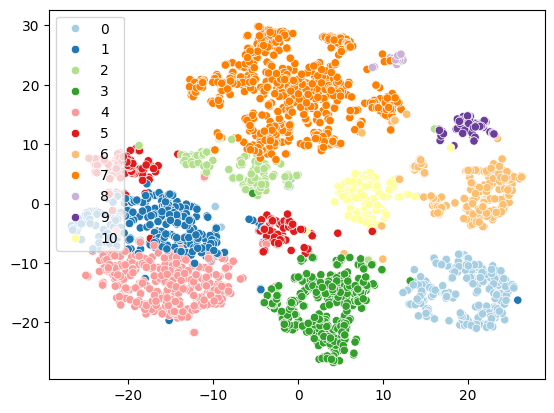

In [16]:
import seaborn as sns
sns.scatterplot(
    x=results.tsne.x, y=results.tsne.y, 
    hue=results.clusters, palette="Paired"
)

Now let's color the embedding with the cell types we identified from `celldex`. We ran the singleR algorithm on the full datasets, but scranpy filtered a few cells during the QC step. Let's identify which cells were kept.

In [17]:
to_keep = [i for i,x in enumerate(results.rna_quality_control_filter) if x == False]
filtered_matches = [matches["best"][i] for i in to_keep]

<Axes: >

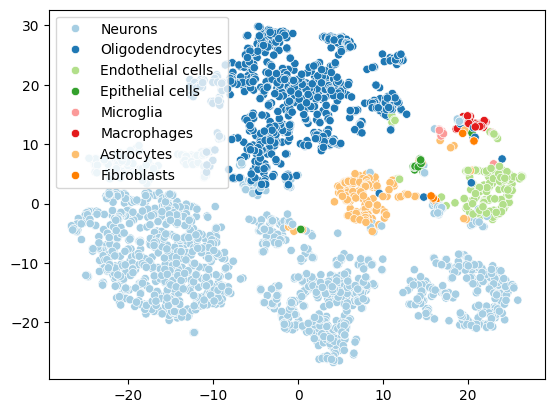

In [18]:
import seaborn as sns
sns.scatterplot(
    x=results.tsne.x, y=results.tsne.y, 
    hue=filtered_matches, palette="Paired"
)

Similarly also explore the UMAP embedding:

<Axes: >

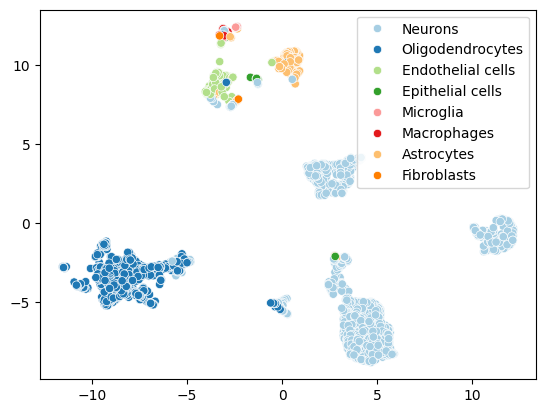

In [19]:
import seaborn as sns
sns.scatterplot(
    x=results.umap.x, y=results.umap.y, 
    hue=filtered_matches, palette="Paired"
)

## 6. Exercises

1. Share or upload your datasets to scrna-seq package. Instructions to upload are available in their respective [R/Bioc](https://bioconductor.org/packages/release/data/experiment/html/scRNAseq.html) and [Python](https://github.com/BiocPy/scrnaseq) packages.
2. Explore top markers for each cluster identified by scranpy.
3. Save your results and explore in [Kana](https://github.com/kanaverse/kana).

## Conclusion

Congratulations! You have now completed the tutorial on accessing single-cell datasets using `scRNAseq` and `ArtifactDB`, and annotating cell types using reference datasets from `celldex`. For more detailed usage and advanced analyses, refer to the respective documentation of these packages.